# Atividade Prática 3 - Função de Rastrigin

Nesta atividade, o algoritmo de evolução diferencial será implementado e utilizado na minimização da função de _Rastrigin_, comumente utilizada para testar o desempenho de métodos de otimização por ser não-linear, não-convexa e multimodal.

O presente estudo se divide em três seções: <a href="#implement">implementação</a> do DE, <a href="#teste">teste</a> do DE e a <a href="#discuss">discussão</a> dos resultados obtidos.

---

<h2 id="implement">Implementação</h2>

#### Bibliotecas necessárias

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Funções e targets para teste do algoritmo

In [2]:
# Função Rastrigin
def rastrigin(x):
    x = x.reshape(1, -1).T
    Q = np.eye(len(x))
    X = Q.dot(x)

    n = len(X)
    F = 0
    
    for i in range(n):
        F = F + X[i]**2 - 10*np.cos(2*np.pi*X[i])
    
    return F[0]
#
# Target da função Rastrigin
rastriginTarget = -20

#### Implementação

In [3]:
def rastriginFitness(indiv):
    '''Retorna erro absoluto entre a avaliação do indivíduo na função alvo (rastrigin)
        e o target da função'''
    global rastriginTarget
    return(np.abs(rastriginTarget - rastrigin(indiv)))

def bestIndividual(pop, fitFunction):
    '''Retorna o melhor indivíduo da população, baseado na função de fitness'''
    indexedFitness = np.zeros([pop.shape[1], 2])
    for j in range(pop.shape[1]):
        indexedFitness[j,:] = [j, fitFunction(pop[:,j])]
    return(pop[:,indexedFitness[:,1].argsort()[0]])

In [4]:
# Loop para evolução da população
def diffEvolution(pop, fitFunction, recombRate, scaleFactor, meanError=1, minimize=1, tol=0.05, maxiter=2000):
    pop = pop.copy()
    newPop = pop.copy()
    
    # n = número de genes; N = tamanho da população
    n, N = pop.shape
    
    # O parâmetro meanError determina se o algoritmo vai se basear no fitness médio da população ou no do 
    # melhor indivíduo. Por padrão, ele se baseia no erro médio.
    if not(meanError):
        error = fitFunction(bestIndividual(pop, fitFunction))
    else:
        error = np.mean([fitFunction(pop[:,i]) for i in range(pop.shape[1])])
    
    niter = 0
    while error > tol and niter < maxiter:
        for i in range(N):
            # Seleciona valores uniformemente em [0, N-1]
            r1, r2, r3, deltai = [int(i) for i in np.random.uniform(0, N-1, 4)]
            for j in range(n):
                # Com probabilidade recombRate, aplica-se mutação a um indivíduo
                if recombRate >= np.random.uniform(0, 1, 1) or j==deltai:
                    newPop[j,i] = pop[j,r1] + scaleFactor*(pop[j,r2] - pop[j,r3])
            if (minimize and (fitFunction(newPop[:,i])<=fitFunction(pop[:,i])) or
                not(minimize) and (fitFunction(newPop[:,i])>=fitFunction(pop[:,i]))):
                # Se o indivíduo mutante é melhor que algum original, o último é substituído
                # pelo primeiro
                pop[:,i] = newPop[:,i]
        
        # Avalia população
        if not(meanError):
            error = fitFunction(bestIndividual(pop, fitFunction))
        else:
            error = np.mean([fitFunction(pop[:,i]) for i in range(pop.shape[1])])
        
        niter += 1
    return(pop, niter)

In [5]:
# Inicialização da população
def initPopulation(n, N, axLimits=[-3,3]):
    pop = np.zeros([n,N])
    for i in range(n):
        for j in range(N):
            pop[i,j] = np.random.uniform(axLimits[0], axLimits[1], 1)
    return(pop)

---

<h2 id="teste">Testes</h2>

### 1. Testes iniciais: apenas uma iteração

#### 1.1 Função Rastrigin

Número de iterações: 78


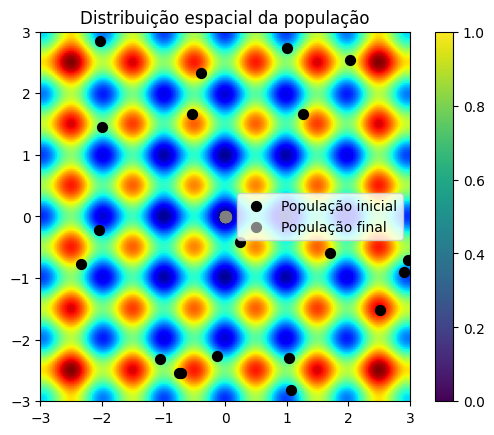

In [6]:
initPopRastrigin = initPopulation(2,20)
finalPopRastrigin, niterRastrigin = diffEvolution(initPopRastrigin, rastriginFitness, recombRate=0.8, scaleFactor=0.8, meanError=1, tol=0.01)
print(f'Número de iterações: {niterRastrigin}')

from itertools import product

x1 = x2 = np.linspace(-3, 3, 150)
x_p = np.array(list(product(x1,x2)))

# Rastrigin
zRastrigin = np.apply_along_axis(rastrigin, 1, x_p)
z = zRastrigin.reshape((len(x1), len(x2)))
initPop = initPopRastrigin
finalPop = finalPopRastrigin

plt.xlim(-3,3)
plt.ylim(-3,3)
plt.imshow(z, extent=(-3,3,-3,3), origin='lower', cmap='jet')
plt.scatter(initPop[1, :], initPop[0, :], color='black', s=50, marker='o', label='População inicial')
plt.scatter(finalPop[1, :], finalPop[0, :], color='grey', s=50, marker='o', label='População final')
plt.colorbar()
plt.legend()
plt.title('Distribuição espacial da população')
plt.show()

### 2. Testes estatísticos

#### 2.1) Número médio de iterações para hiperparâmetros arbitrários

In [7]:
totalItersRastrigin = np.array([])
for i in range(100):
    initPopRastrigin = initPopulation(2,50)
    finalPopRastrigin, niterRastrigin = diffEvolution(initPopRastrigin, rastriginFitness, recombRate=0.8, scaleFactor=0.8, meanError=1, tol=0.01, maxiter=5000)
    totalItersRastrigin = np.append(totalItersRastrigin, niterRastrigin)

meanIterRastrigin = round(np.mean(totalItersRastrigin),3)
stdIterRastrigin = round(np.std(totalItersRastrigin),3)
print(f'''\nNúmero médio de iterações para convergência (Rastrigin): {meanIterRastrigin}
Desvio-padrão do número de iterações para convergência (Rastrigin): {stdIterRastrigin}''')



Número médio de iterações para convergência (Rastrigin): 67.07
Desvio-padrão do número de iterações para convergência (Rastrigin): 8.678


In [8]:
from tqdm import tqdm
from IPython.display import clear_output

# Grid search para seleção de hiperparâmetros na min. da função de Rastrigin
itersRastriginVariableCAndF = np.zeros((25,3))
iter = 0
for recombRate in tqdm(np.linspace(0.6, 0.9, 5)):
    for scaleFactor in np.linspace(0.7, 0.9, 5):
            totalItersRastrigin = np.array([])
            for i in range(10):
                initPopRastrigin = initPopulation(2,50)
                finalPopRastrigin, niterRastrigin = diffEvolution(initPopRastrigin, rastriginFitness, recombRate=recombRate, scaleFactor=scaleFactor, meanError=1, tol=0.01, maxiter=5000)
                totalItersRastrigin = np.append(totalItersRastrigin, niterRastrigin)
            itersRastriginVariableCAndF[iter] = [recombRate, scaleFactor, np.mean(totalItersRastrigin)]
            iter+=1
CstarRastrigin, FstarRastrigin, niterHPOrastrigin = itersRastriginVariableCAndF[itersRastriginVariableCAndF[:,2].argmin(), :]
clear_output(wait=1)

print(f'''Os melhores valores obtidos para a probabilidade de recombinação e para o fator de escala são, 
respectivamente, {CstarRastrigin} e {FstarRastrigin} na minimização da função de Rastrigin. Número médio de iterações
com esses hiperparâmetros: {niterHPOrastrigin}''')

Os melhores valores obtidos para a probabilidade de recombinação e para o fator de escala são, 
respectivamente, 0.9 e 0.9 na minimização da função de Rastrigin. Número médio de iterações
com esses hiperparâmetros: 56.3


---

<h2 id="discuss">Discussão</h2>

Os experimentos realizados demonstraram a enorme eficácia do algoritmo de evolução diferencial em problemas de otimização. Mesmo para a função de Rastrigin, conhecida por ser multimodal, não-linear e não-convexa, o algoritmo convergiu para o mínimo global em pouquíssimas iterações e com um custo computacional muito baixo.

O algoritmo ainda se mostrou pouco sensível à tunagem de hiperparâmetros, obtendo bons resultados para todas as combinações de parâmetros testadas. O único fator para o qual observou-se uma mudança razoável no desempenho do algoritmo foi o tamanho da população, sendo a convergência facilitada para populações maiores (iniciei os testes com 20 indivíduos, mas logo aumentei para 50 de forma a acelerar a convergência). 

Por fim, o algoritmo ainda apresentou baixa variância, se mostrando robusto, apesar de estocástico.

---